In [1]:
import os
if os.getcwd().replace("\\", "/").split("/")[-1] in ["notebooks", "scripts"]:
    os.chdir("..")

In [2]:
import duckdb
import pandas as pd
import numpy as np


In [3]:
import duckdb
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

In [4]:
con = duckdb.connect('data/exploitation.db')
con.execute("show tables").fetchall()

[('houses',),
 ('sandbox_T_apartment_S_ca',),
 ('sandbox_T_apartment_S_ca_X_test_processed',),
 ('sandbox_T_apartment_S_ca_X_train_processed',),
 ('sandbox_T_apartment_S_ca_Xs_test_processed',),
 ('sandbox_T_apartment_S_ca_Xs_train_processed',),
 ('sandbox_T_apartment_S_ca_preprocessed',),
 ('sandbox_T_apartment_S_ca_y_test_processed',),
 ('sandbox_T_apartment_S_ca_y_train_processed',),
 ('sandbox_T_apartment_S_ca_ys_test_processed',),
 ('sandbox_T_apartment_S_ca_ys_train_processed',),
 ('sandbox_T_apartment_S_ga_fl',),
 ('sandbox_T_apartment_S_ga_fl_preprocessed',),
 ('sandbox_T_apartment_condo_S_ga_fl_nc_sc',),
 ('sandbox_T_house_apartment_S_or',)]

In [7]:
df = con.execute("select * from sandbox_T_apartment_S_ca").df()

In [40]:
con.close()

In [8]:
def numeric_description(df):
    df_numeric_description = df.describe().transpose()
    df_numeric_description["missings"] = len(df) - df_numeric_description["count"]
    #df.shape #len df
    df_numeric_description["missing ratio (%)"] = round(df_numeric_description["missings"]*100/len(df), 2)
    return df_numeric_description.drop(['count'], axis=1)


In [9]:
def description_categorical(df):
    n = len(df)
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columns = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    cat_dict = dict({"": [],"#Levels":[],"Max Freq (Abs,%)":[],"Min Freq (Abs,%)":[],"#Unknows":[],"Unknows (%)":[]})

    for i,t in columns:

        if t != "object":
            continue

        freq = dict(df[i].apply(lambda x: str(x)).value_counts())
        freq_list = [(y,x) for x,y in freq.items()]

        max_freq = max(freq_list)[1] + " (" + str(max(freq_list)[0]) 
        max_freq += (", " + str(round(max(freq_list)[0]*100/n,2)) + ")")

        min_freq = min(freq_list)[1] + " (" + str(min(freq_list)[0]) 
        min_freq += (", " + str(round(min(freq_list)[0]*100/n,2)) + ")")

        cat_dict[""].append(i)
        cat_dict["#Levels"].append(len(freq_list))
        cat_dict["Max Freq (Abs,%)"].append(max_freq)
        cat_dict["Min Freq (Abs,%)"].append(min_freq)
        
        if "unknow" in freq:
            cat_dict["#Unknows"].append(freq["unknow"])
            cat_dict["Unknows (%)"].append(round(freq["unknow"]*100 /n,2))

        else:
            cat_dict["#Unknows"].append(0)
            cat_dict["Unknows (%)"].append(0)

    return pd.DataFrame(cat_dict)


In [10]:
def barplot(df,top=10,freq=False):
    n = len(df)
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columns = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    

    for i,t in columns:

        if t != "object":
            continue

        if freq:
            df[i].value_counts().head(top).apply(lambda x : x/n).plot( kind='bar')
        else:
            df[i].value_counts().head(top).plot( kind='bar')
        plt.title(i)
        plt.show()

In [11]:
def hist(df, bins=50):
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columnss = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    for i,t in columnss:

        if t != "float64" and t != "int32":
            continue

        df[i].hist(bins=min(bins,len(df[i].unique())))
        plt.title(i)
        plt.show()

# input: dataframe
# output: box plot of the numerical features from the dataframe
def boxplot(df):
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columnss = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    for i,t in columnss:

        if t != "float64" and t != "int32":
            continue

        df.loc[:, [i]].boxplot();
        plt.title(i)
        plt.show()

In [12]:
def log_transformation(df,cols=[]):
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columnss = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    cols = set(cols)
    for i,t in columnss:

        if (t != "float64" and t != "int32") or i not in cols:
            continue
            
        print(i)
        df[i] = df[i].map(lambda x: np.log(x+1))

In [13]:
def outliers_cutpoints(df,col = "price",alpha=0.01):
  var = np.sort(df[col].to_numpy())
  var = var[~np.isnan(var)]
  n = var.size
  k = round(n*alpha/2)
  bot = k
  top = n-1-k

  return (var[bot],var[top])

In [14]:
def clean_outliers(df,cols=[]):
    name_columns = list(df.columns)
    types_columns = [str(x) for x in list(df.dtypes)]
    columnss = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]
    
    cols = set(cols)
    for i,t in columnss:

        if (t != "float64" and t != "int32") or i not in cols:
            continue
            
        print(i)
        (bot, top) = outliers_cutpoints(df,col = i,alpha=0.01)
        df[i] = df[i].map(lambda x: x if x >= bot and x<= top else np.nan)

In [15]:
numeric_description(df)

,mean,std,min,25%,50%,75%,max,missings,missing ratio (%)
id,7.043617e+09,7.678639e+06,7.004627e+09,7.040167e+09,7.046563e+09,7.049414e+09,7.050110e+09,0.0,0.00
price,3.036520e+03,1.461503e+05,1.000000e+00,1.315000e+03,1.675000e+03,2.150000e+03,2.170191e+07,259.0,0.95
sqfeet,8.912317e+02,8.441264e+02,1.000000e+00,7.000000e+02,8.600000e+02,1.030000e+03,9.524200e+04,69.0,0.25
beds,1.650216e+00,7.520621e-01,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,5.000000e+00,0.0,0.00
baths,1.424636e+00,5.286821e-01,0.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,5.000000e+00,0.0,0.00
lat,3.592446e+01,2.123666e+00,3.234960e+01,3.403530e+01,3.560750e+01,3.778920e+01,4.553430e+01,0.0,0.00
long,-1.194733e+02,1.806714e+00,-1.242030e+02,-1.212680e+02,-1.196520e+02,-1.179133e+02,-7.237180e+01,0.0,0.00
num_hospitals,1.301928e+03,1.813045e+03,0.000000e+00,1.610000e+02,6.000000e+02,1.776000e+03,1.391000e+04,0.0,0.00
num_beds,2.377631e+05,3.641523e+05,2.600000e+01,2.926300e+04,1.003800e+05,2.937530e+05,3.035240e+06,3.0,0.01
hospital_type_general,1.001935e+03,1.438659e+03,0.000000e+00,1.240000e+02,4.320000e+02,1.235000e+03,1.092000e+04,0.0,0.00


In [16]:
description_categorical(df)

,,#Levels,"Max Freq (Abs,%)","Min Freq (Abs,%)",#Unknows,Unknows (%)
0,url,27314,https://yubasutter.craigslist.org/apa/d/yuba-c...,https://bakersfield.craigslist.org/apa/d/1-bed...,0,0.00
1,region,29,"stockton (2396, 8.77)","susanville (6, 0.02)",0,0.00
2,region_url,29,"https://stockton.craigslist.org (2396, 8.77)","https://susanville.craigslist.org (6, 0.02)",0,0.00
3,type,1,"apartment (27314, 100.0)","apartment (27314, 100.0)",0,0.00
4,cats_allowed,2,"Yes (19837, 72.63)","No (7477, 27.37)",0,0.00
5,dogs_allowed,2,"Yes (18978, 69.48)","No (8336, 30.52)",0,0.00
6,smoking_allowed,2,"Yes (19876, 72.77)","No (7438, 27.23)",0,0.00
7,wheelchair_access,2,"No (24535, 89.83)","Yes (2779, 10.17)",0,0.00
8,electric_vehicle_charge,2,"No (25903, 94.83)","Yes (1411, 5.17)",0,0.00
9,comes_furnished,2,"No (26632, 97.5)","Yes (682, 2.5)",0,0.00


In [17]:
df = df.drop(["id", "url", "region_url", "image_url", "description"], axis=1)

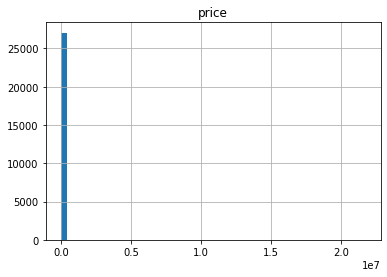

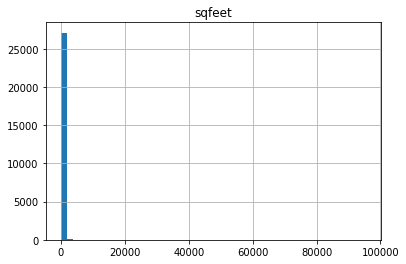

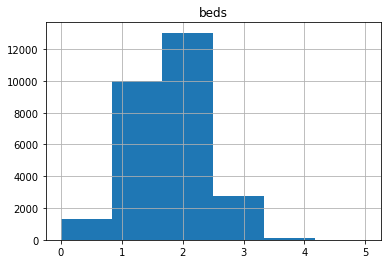

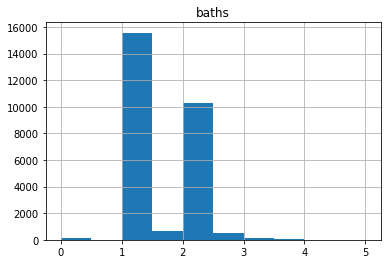

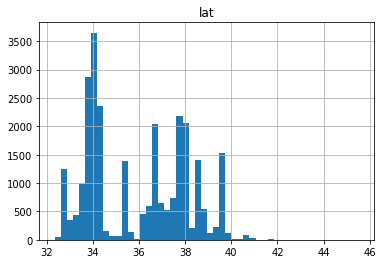

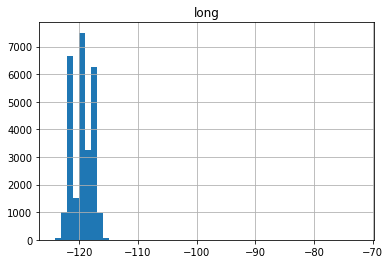

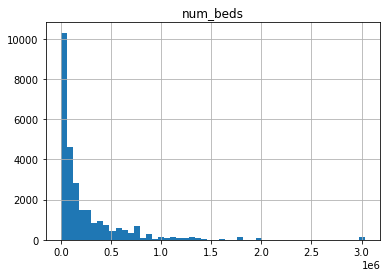

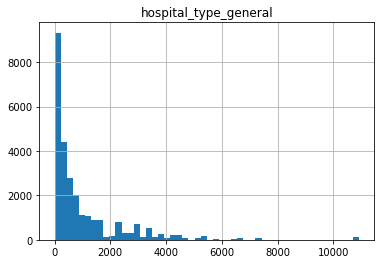

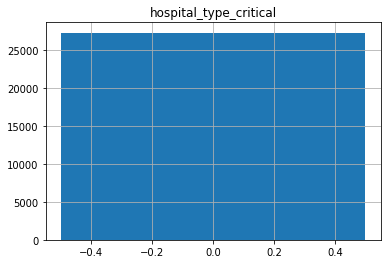

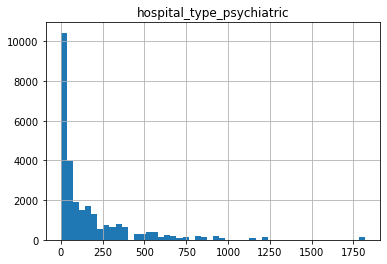

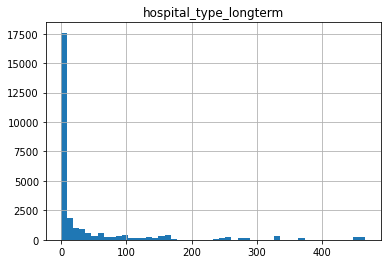

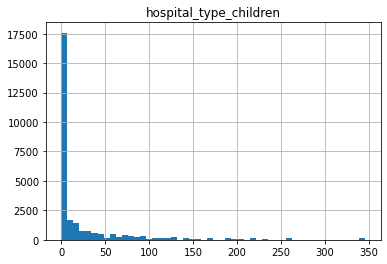

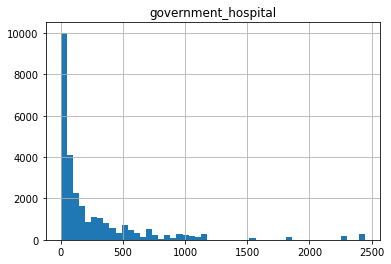

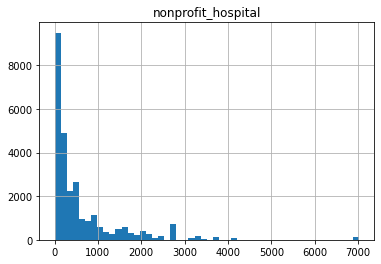

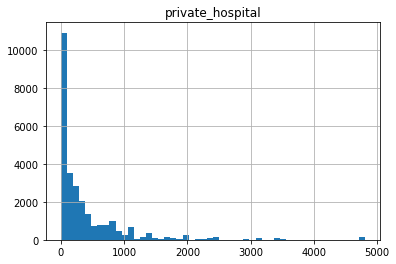

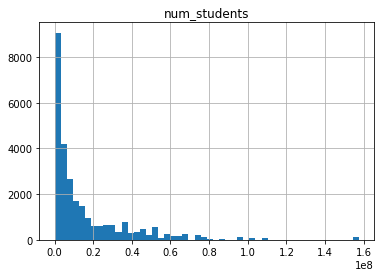

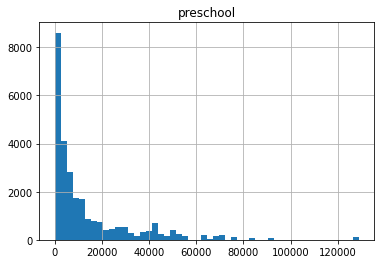

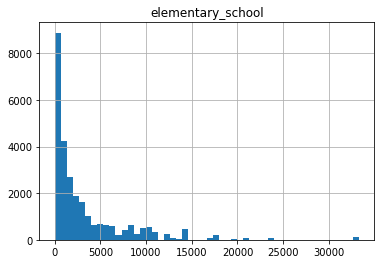

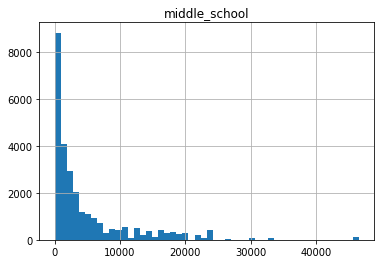

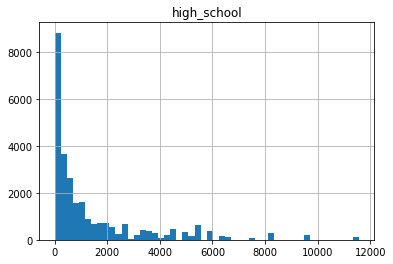

In [18]:
hist(df)

In [19]:
name_columns = list(df.columns)
types_columns = [str(x) for x in list(df.dtypes)]
i = 1
columns = [(name_columns[i],types_columns[i]) for i in range(len(name_columns))]

num_var = []
cat_var = []

for i,t in columns:
    if t == "object":
      cat_var.append(i)
    else:
      num_var.append(i)

print(cat_var)
print()
print(num_var)

['region', 'type', 'cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 'laundry_options', 'parking_options', 'state']

['price', 'sqfeet', 'beds', 'baths', 'lat', 'long', 'num_hospitals', 'num_beds', 'hospital_type_general', 'hospital_type_critical', 'hospital_type_psychiatric', 'hospital_type_longterm', 'hospital_type_children', 'government_hospital', 'nonprofit_hospital', 'private_hospital', 'num_schools', 'num_students', 'preschool', 'elementary_school', 'middle_school', 'high_school']


## Log transformations and clean outliers

In [20]:
num_cols = set(num_var) - set(["beds","baths","lat","long"])
log_transformation(df,cols=num_cols)


price
sqfeet
num_beds
hospital_type_general
hospital_type_critical
hospital_type_psychiatric
hospital_type_longterm
hospital_type_children
government_hospital
nonprofit_hospital
private_hospital
num_students
preschool
elementary_school
middle_school
high_school


In [21]:
num_cols = set(num_var) - set(["lat","long"])
clean_outliers(df,cols=num_cols)

price
sqfeet
beds
baths
num_beds
hospital_type_general
hospital_type_critical
hospital_type_psychiatric
hospital_type_longterm
hospital_type_children
government_hospital
nonprofit_hospital
private_hospital
num_students
preschool
elementary_school
middle_school
high_school


In [22]:
numeric_description(df)

,mean,std,min,25%,50%,75%,max,missings,missing ratio (%)
price,7.429321,0.369410,5.736572,7.186144,7.424165,7.671361,8.590630,527.0,1.93
sqfeet,6.740923,0.292905,5.505332,6.552508,6.758095,6.936343,7.550135,330.0,1.21
beds,1.648130,0.747634,0.000000,1.000000,2.000000,2.000000,4.000000,17.0,0.06
baths,1.427316,0.510886,1.000000,1.000000,1.000000,2.000000,3.000000,176.0,0.64
lat,35.924461,2.123666,32.349600,34.035300,35.607500,37.789200,45.534300,0.0,0.00
long,-119.473324,1.806714,-124.203000,-121.268000,-119.652000,-117.913250,-72.371800,0.0,0.00
num_hospitals,1301.927876,1813.044534,0.000000,161.000000,600.000000,1776.000000,13910.000000,0.0,0.00
num_beds,11.336727,1.642017,6.306275,10.313476,11.516728,12.587604,14.481004,270.0,0.99
hospital_type_general,5.899343,1.607475,1.609438,4.844187,6.070738,7.119636,8.884195,250.0,0.92
hospital_type_critical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00


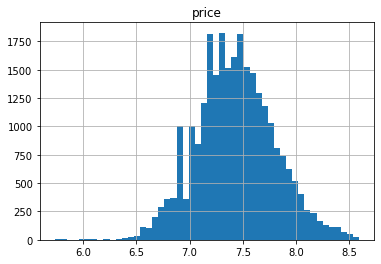

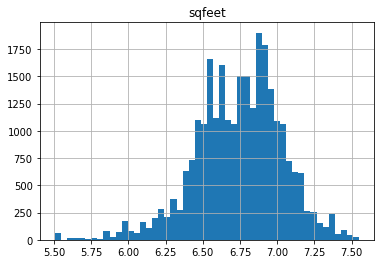

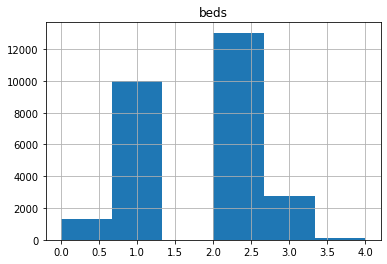

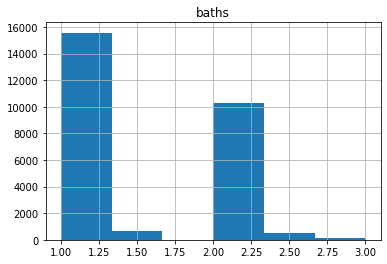

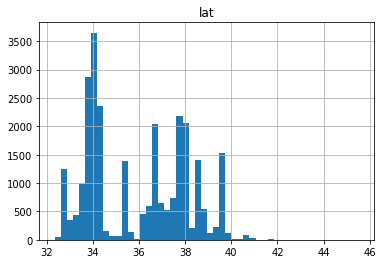

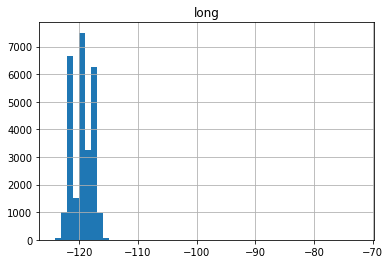

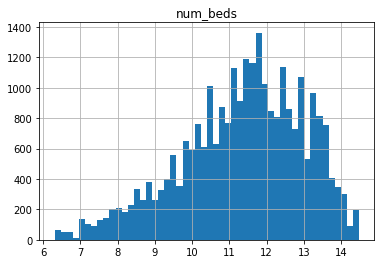

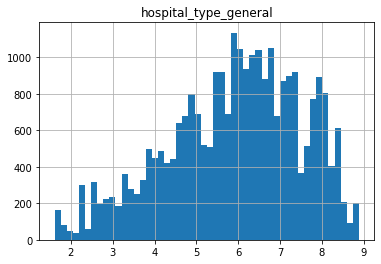

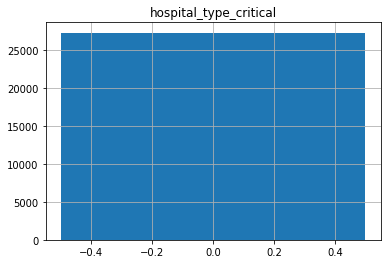

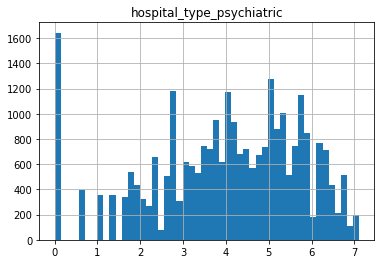

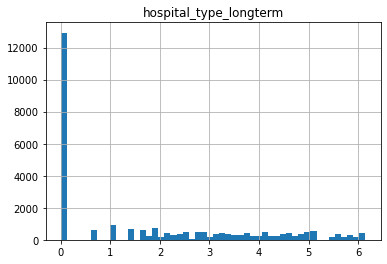

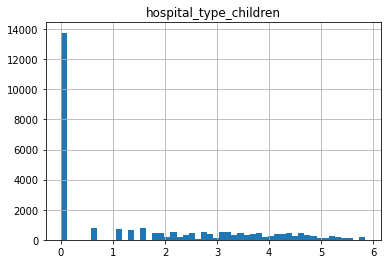

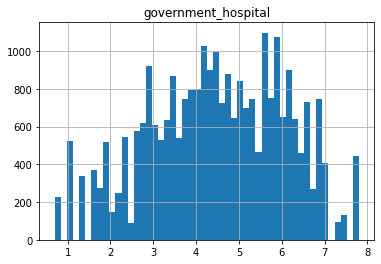

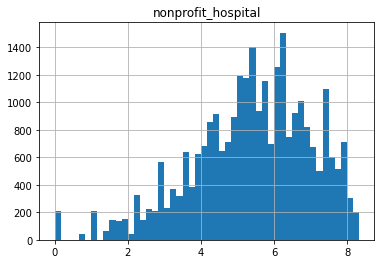

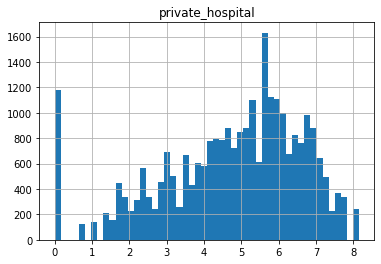

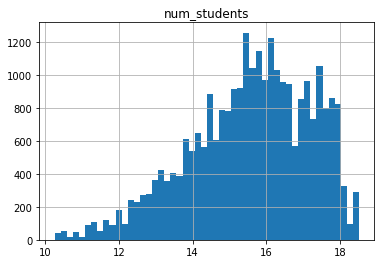

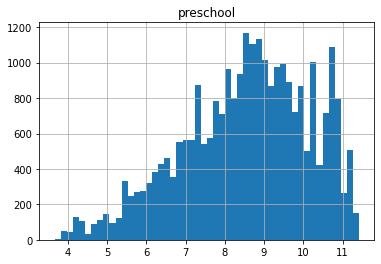

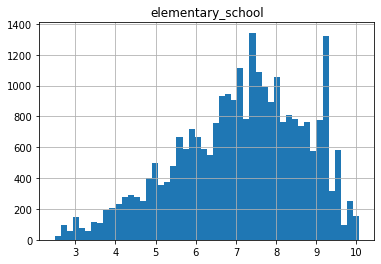

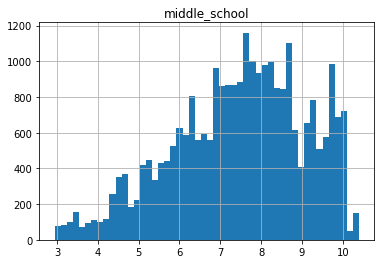

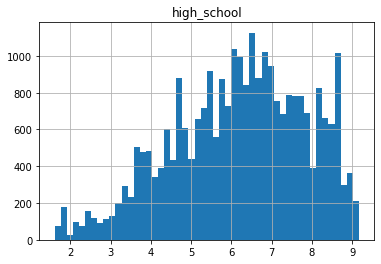

In [23]:
hist(df)

## imputation

In [24]:
df = df.dropna(subset=["price"])
print(df.shape[0])
df.describe()

26787


,price,sqfeet,beds,baths,lat,long,num_hospitals,num_beds,hospital_type_general,hospital_type_critical,...,hospital_type_children,government_hospital,nonprofit_hospital,private_hospital,num_schools,num_students,preschool,elementary_school,middle_school,high_school
count,26787.000000,26525.000000,26774.000000,26630.000000,26787.00000,26787.000000,26787.000000,26523.000000,26544.000000,26787.0,...,26787.000000,26682.000000,26660.000000,26660.000000,26787.000000,26533.000000,26527.000000,26531.000000,26535.000000,26579.000000
mean,7.429321,6.741910,1.649623,1.427882,35.90476,-119.466540,1306.664949,11.339070,5.900793,0.0,...,1.498425,4.473342,5.389981,4.751703,24020.498152,15.564079,8.543995,7.112163,7.468557,6.191054
std,0.369410,0.286442,0.741845,0.509191,2.12151,1.813768,1818.887789,1.644966,1.610333,0.0,...,1.795470,1.608317,1.635231,1.893282,32961.532355,1.646874,1.611209,1.591423,1.621704,1.664329
min,5.736572,5.505332,0.000000,1.000000,32.34960,-124.203000,0.000000,6.306275,1.609438,0.0,...,0.000000,0.693147,0.000000,0.000000,0.000000,10.259447,3.663562,2.484907,2.944439,1.609438
25%,7.186144,6.552508,1.000000,1.000000,34.02940,-121.269000,161.000000,10.309586,4.844187,0.0,...,0.000000,3.295837,4.369448,3.583519,2847.000000,14.486245,7.442493,6.023448,6.347389,5.030438
50%,7.424165,6.758095,2.000000,1.000000,35.44180,-119.652000,600.000000,11.522767,6.070738,0.0,...,0.000000,4.510860,5.525453,5.087596,10336.000000,15.739794,8.691651,7.288244,7.621195,6.336826
75%,7.671361,6.935370,2.000000,2.000000,37.78445,-117.902000,1776.000000,12.587604,7.119636,0.0,...,3.044522,5.771441,6.591674,6.111467,30320.000000,16.878816,9.782901,8.314097,8.692490,7.467942
max,8.590630,7.550135,4.000000,3.000000,45.53430,-72.371800,13910.000000,14.481004,8.884195,0.0,...,5.849325,7.803435,8.318986,8.154500,224380.000000,18.514489,11.420646,10.066244,10.395711,9.167120


In [25]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

df_num = df.select_dtypes(include=np.number)
numeric_cols = df_num.columns

lr = LinearRegression()
imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
df_num = imp.fit_transform(df_num)
df_num = pd.DataFrame(df_num, columns=numeric_cols)


[IterativeImputer] Completing matrix with shape (26787, 22)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.96
[IterativeImputer] Change: 15.577796830062377, scaled tolerance: 224.38 
[IterativeImputer] Early stopping criterion reached.


In [26]:
print(type(df_num))

for i in numeric_cols:
    df.loc[:,i] = df_num.loc[:,i]
print(df.shape[0])
numeric_description(df)

<class 'pandas.core.frame.DataFrame'>
26787


,mean,std,min,25%,50%,75%,max,missings,missing ratio (%)
price,7.429921,0.369279,5.736572,7.186144,7.424165,7.671361,8.590630,519.0,1.94
sqfeet,6.743645,0.287859,5.505332,6.553933,6.758095,6.938284,7.770440,519.0,1.94
beds,1.649524,0.741183,0.000000,1.000000,2.000000,2.000000,4.000000,519.0,1.94
baths,1.428962,0.509152,0.555518,1.000000,1.000000,2.000000,3.000000,519.0,1.94
lat,35.903947,2.121980,32.349600,34.029000,35.441800,37.787125,45.534300,519.0,1.94
long,-119.468137,1.810242,-124.203000,-121.269000,-119.652000,-117.900750,-72.371800,519.0,1.94
num_hospitals,1311.141046,1823.545917,0.000000,161.000000,600.000000,1776.000000,13910.000000,519.0,1.94
num_beds,11.331895,1.648224,5.864527,10.284558,11.530972,12.576777,14.481004,519.0,1.94
hospital_type_general,5.895923,1.615105,1.014521,4.828314,6.070738,7.119636,8.884195,519.0,1.94
hospital_type_critical,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,519.0,1.94


## Transformations

<AxesSubplot:>

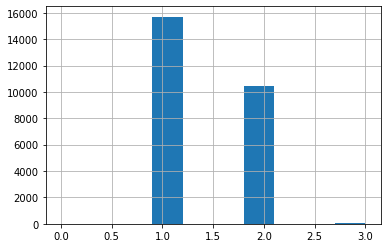

In [27]:
df["N_baths"] = df["baths"].apply(np.floor)
df["N_baths"].hist()

In [28]:
#df["half_baths"] = "Yes" if 0 < df["baths"] - df["N_baths"].item() else "No"
df["half_baths"] =  (df["baths"] - df["N_baths"]).apply(lambda x:"Yes" if 0 < x else "No") 


In [29]:
# half_baths,hospital_type_critical, hospital_type_longterm, hospital_type_children

df["b_hospital_type_critical"] = df["hospital_type_critical"].apply(lambda x:"Yes" if 0 < x else "No")
df["b_hospital_type_longterm"] = df["hospital_type_longterm"].apply(lambda x:"Yes" if 0 < x else "No")
df["b_hospital_type_children"] = df["hospital_type_children"].apply(lambda x:"Yes" if 0 < x else "No")
df["b_type"] = df["type"].apply(lambda x:"Apartment" if "apartment" == x else "No-Apartment")



In [30]:
def equal_split(vector, k):
    n = len(vector)
    vec = sorted(list(vector))
    cuts = []
    for i in range(1,k):
        j = round((n+1)*i/k)
        cuts.append(vec[j])

    return cuts


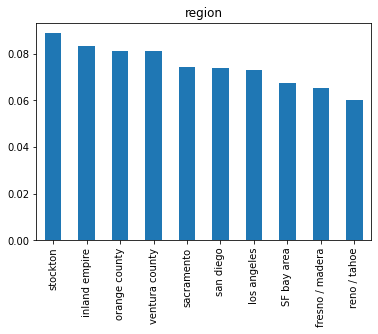

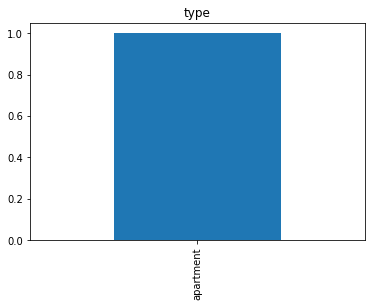

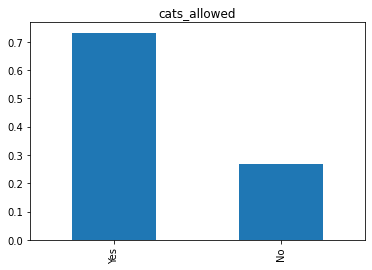

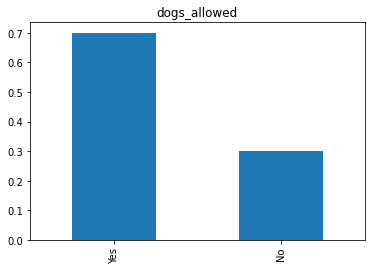

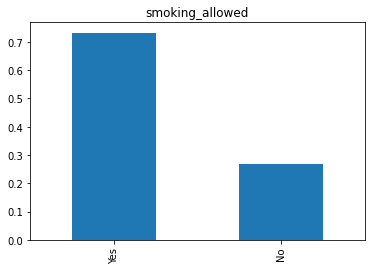

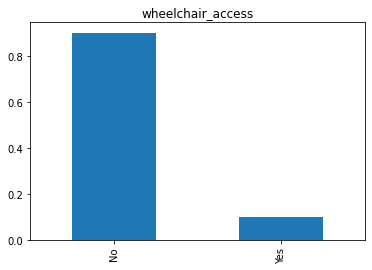

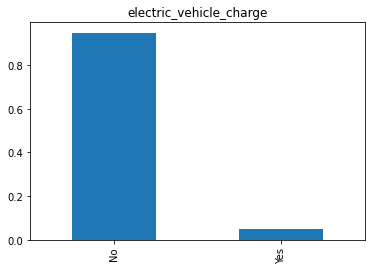

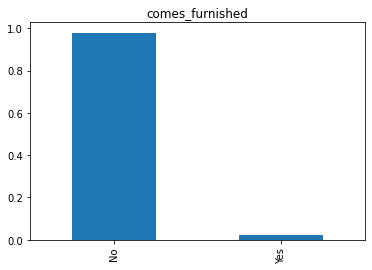

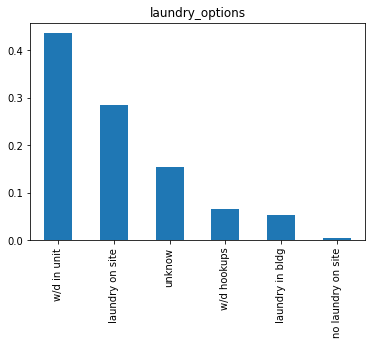

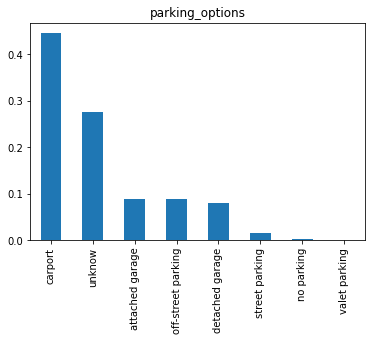

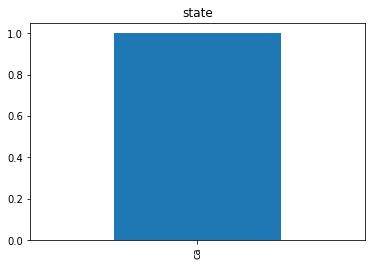

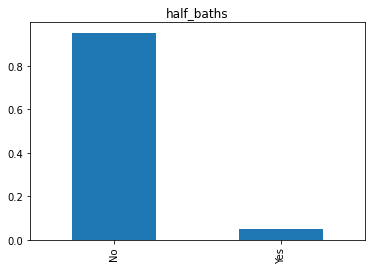

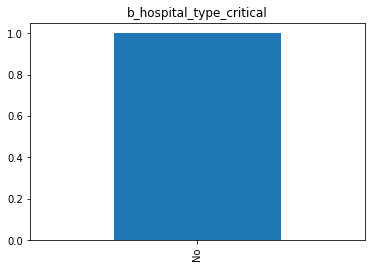

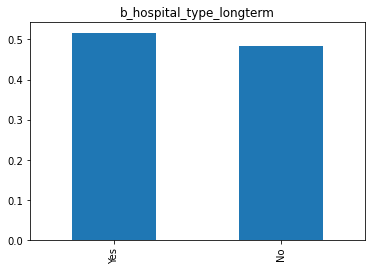

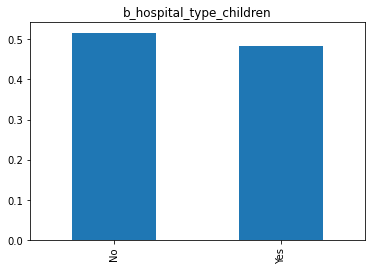

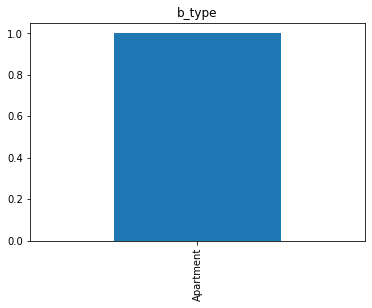

In [31]:
barplot(df,freq=True)

# get the data & encode

In [32]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [33]:
# select columns
y_col = 'price'
exclude_cols = ['region']
x_cols_onehot = ['type', 'state', 'laundry_options', 'parking_options']
x_cols_binary = ['cats_allowed', 'dogs_allowed', 'smoking_allowed', 'wheelchair_access', 'electric_vehicle_charge', 'comes_furnished', 'half_baths'] + [
    c for c in df.columns if c[0:2]=='b_'
]
x_cols_numeric = [c for c in df.columns if not c in [y_col] + exclude_cols + x_cols_onehot + x_cols_binary]

In [34]:
# make everything numeric and scaled
bin2num = lambda x: 1 if x=='Yes' or x==1 or x=="Apartment" else 0
for col in x_cols_binary:
    df[col] = df[col].apply(bin2num)

# one-hot encoding in categorical variables
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[x_cols_onehot])

cols_encoded = []
for i in range(len(x_cols_onehot)):
  col = x_cols_onehot[i]
  print("col: ", col)
  for name in enc.categories_[i]:
    cols_encoded.append(str(col+'_'+name[0:].strip()).lower().strip())
    print("name: ", str(col+'_'+name[0:].strip()).lower().strip())

df_onehot_encoded = pd.DataFrame(enc.transform(df[x_cols_onehot]).toarray(), columns = cols_encoded)

# scaling numerical variables:
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df[x_cols_numeric]), columns = x_cols_numeric)



col:  type
name:  type_apartment
col:  state
name:  state_ca
col:  laundry_options
name:  laundry_options_laundry in bldg
name:  laundry_options_laundry on site
name:  laundry_options_no laundry on site
name:  laundry_options_unknow
name:  laundry_options_w/d hookups
name:  laundry_options_w/d in unit
col:  parking_options
name:  parking_options_attached garage
name:  parking_options_carport
name:  parking_options_detached garage
name:  parking_options_no parking
name:  parking_options_off-street parking
name:  parking_options_street parking
name:  parking_options_unknow
name:  parking_options_valet parking


In [35]:
# columns in the one-hot encoding
print(enc.feature_names_in_)
print(enc.categories_)

# parameters used in the scaling
print(scaler.feature_names_in_)
print(scaler.mean_)
print(scaler.scale_)

['type' 'state' 'laundry_options' 'parking_options']
[array(['apartment'], dtype=object), array(['ca'], dtype=object), array(['laundry in bldg', 'laundry on site', 'no laundry on site',
       'unknow', 'w/d hookups', 'w/d in unit'], dtype=object), array(['attached garage', 'carport', 'detached garage', 'no parking',
       'off-street parking', 'street parking', 'unknow', 'valet parking'],
      dtype=object)]
['sqfeet' 'beds' 'baths' 'lat' 'long' 'num_hospitals' 'num_beds'
 'hospital_type_general' 'hospital_type_critical'
 'hospital_type_psychiatric' 'hospital_type_longterm'
 'hospital_type_children' 'government_hospital' 'nonprofit_hospital'
 'private_hospital' 'num_schools' 'num_students' 'preschool'
 'elementary_school' 'middle_school' 'high_school' 'N_baths']
[ 6.74364501e+00  1.64952390e+00  1.42896215e+00  3.59039474e+01
 -1.19468137e+02  1.31114105e+03  1.13318953e+01  5.89592312e+00
  0.00000000e+00  3.98427259e+00  1.73253792e+00  1.49687317e+00
  4.46932932e+00  5.39385992e

In [36]:
# dataset with encoding columns to numeric
df_encoded = pd.concat(objs=[
    df[x_cols_binary], df_onehot_encoded, df[x_cols_numeric], df[[y_col]]
], axis = 1
)

# dataset with encoding + scaling
df_scaled = pd.concat(objs=[
    df[x_cols_binary], df_onehot_encoded, df_scaled, df[[y_col]]
], axis = 1
)

#df_processed.fillna(0, inplace=True)
#df_processed.head()

In [37]:
# split training set and test set and validation set
df_train, df_test = np.split(
    df_encoded.sample(frac=1, random_state=777),
    [ int(0.7*len(df_encoded))  ]
    )

df_train2, df_test2 = np.split(
    df_scaled.sample(frac=1, random_state=777),
    [ int(0.7*len(df_scaled))  ]
    )

X_train = df_train.drop(y_col, axis=1)
y_train = df_train[y_col]
X_test = df_test.drop(y_col, axis=1)
y_test = df_test[y_col]

## Test Script

In [41]:
con = duckdb.connect('data/exploitation.db')
con.execute("show tables").fetchall()

[('houses',),
 ('sandbox_T_apartment_S_ca',),
 ('sandbox_T_apartment_S_ca_X_test_processed',),
 ('sandbox_T_apartment_S_ca_X_train_processed',),
 ('sandbox_T_apartment_S_ca_Xs_test_processed',),
 ('sandbox_T_apartment_S_ca_Xs_train_processed',),
 ('sandbox_T_apartment_S_ca_preprocessed',),
 ('sandbox_T_apartment_S_ca_y_test_processed',),
 ('sandbox_T_apartment_S_ca_y_train_processed',),
 ('sandbox_T_apartment_S_ca_ys_test_processed',),
 ('sandbox_T_apartment_S_ca_ys_train_processed',),
 ('sandbox_T_apartment_S_ga_fl',),
 ('sandbox_T_apartment_S_ga_fl_preprocessed',),
 ('sandbox_T_apartment_condo_S_ga_fl_nc_sc',),
 ('sandbox_T_house_apartment_S_or',)]

In [42]:
df = con.execute("select * from sandbox_T_apartment_S_ca_X_train_processed").df()

In [43]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cats_allowed,18938.0,0.730278,0.443827,0.000000,0.000000,1.000000,1.000000,1.000000
dogs_allowed,18938.0,0.698490,0.458926,0.000000,0.000000,1.000000,1.000000,1.000000
smoking_allowed,18938.0,0.729591,0.444183,0.000000,0.000000,1.000000,1.000000,1.000000
wheelchair_access,18938.0,0.099852,0.299811,0.000000,0.000000,0.000000,0.000000,1.000000
electric_vehicle_charge,18938.0,0.051273,0.220559,0.000000,0.000000,0.000000,0.000000,1.000000
comes_furnished,18938.0,0.025135,0.156538,0.000000,0.000000,0.000000,0.000000,1.000000
half_baths,18938.0,0.049372,0.216648,0.000000,0.000000,0.000000,0.000000,1.000000
b_hospital_type_critical,18938.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
b_hospital_type_longterm,18938.0,0.528567,0.499196,0.000000,0.000000,1.000000,1.000000,1.000000
b_hospital_type_children,18938.0,0.491604,0.499943,0.000000,0.000000,0.000000,1.000000,1.000000


In [44]:
con.close()